**Rapport de Claire KOECHLIN et Eryne THOMAS - 31 mai 2023**
# Dynamical Model for Building Energy Management

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import files.dm4bem as dm4bem

# Sommaire
Partie 1 - Modèle
>Description du sujet  
>Description des paramètres  
>Calcul des Conductances Thermiques  
>Calcul des Capacités Thermiques  
>Equations Différentielles Algébriques

Partie 2 - Régime Permanent
> Système d'Equations Différentielles  
> Représentation d'état

Partie 3 - Modèle Dynamique : Réponse à un échelon  
>Détermination du pas de temps  
>Détermination du temps total  
>Hypothèses de Simulation  
>Résolution Numérique

## PARTIE 1 - Modèle #  
### Description du sujet #

![Alt text](Scheme_building_Koechlin_Thomas.png)

> Figure 1 : Schéma de notre modèle 
Le mur entre la pièce 1 et l'extérieur est appelé mur 1.  
Le mur entre la pièce 2 et l'extérieur est appelé mur 2.  
Le mur entre les deux pièces est appelé mur intérieur (int).

Les portes et les murs sont en bois, $lambois$ est le coefficient de conductivité, $Csp$ est la capacité spécifique du bois et $mv$ la masse volumique.

In [3]:
lambois = 0.077 
Csp = 1250
mv = 370 #kg/m3

$Up$ est le coefficient thermique de la porte, en bois, et $Uf$ est le coeffcient thermique de la fenêtre, prise en double vitrage.

In [4]:
Up = 2.5
Uf = 1.5

On impose la température extérieure et on utilise un controleur dans chaque pièce pour imposer la température intérieure. Il y a également un flux dans chaque pièce lié à la présence de personnes.

![Alt text](Thermal_circuit.jpeg)

> Figure 2 : Schéma Thermique

### Description des paramètres #
$Text$ est la température à l'extérieur et $Tc$ est la température imposée à l'intérieur.  
$hconvext$ est le coefficent de convection sur la surface extérieure des murs.  $hconvint$ est le coefficient de convection sur la surface intérieure des murs.  

In [5]:
Text = 5+273
Tc = 20+273
hconvext = 10 
hconvint = 2

$emext = 30 cm$ est l'épaisseur des murs en contact avec l'extérieur et $emint = 10 cm$ du mur entre les deux pièces.  
$ep = 10 cm$ est l'épaisseur des portes et $ef = 3 cm$ celle des fenêtres.  
$Spf = 2m²$ est la surface des portes et des fenêtres.  
$Sm1 = 26 m²$ est la surface du mur 1.  
$Sm = 28 m²$ est la surface du mur intérieur et du mur 2

In [6]:
emext = 30*(10**(-2))
emint = 10*(10**(-2))
ep = 10*(10**(-2))
ef = 3*(10**(-2))
Spf = 2
Sm1 = 30-2*Spf
Sm = 30-Spf

$Q1$ et $Q2$ correspond aux emissions de chaleur par les personnes et appareils présentes dans les pièces 1 et 2, $phi1$ et $phi2$ sont issus du rayonnement du soleil

In [7]:

Q1= 300 #1 personne = 80W
Q2= 300 
E = 100 #éclairement du soleil en W/m2
phi1 =E*Sm1*0.8 #corps gris
phi2 =E*Sm*0.8 #corps gris

Le volume d'air renouvellé par advection est $Va$, et $Vadot$ est le flux d'air.  $rhoair$ est la masse volumique de l'air et $Cair$ est la capacité thermique de l'air.

In [8]:
Va = 10*10*3
ACH = 1
Va_dot = ACH/3600 * Va
rhoair = 1.3
Cair = 1

### Calcul des Conductances Thermiques #
#### Advection #
$G_{advection} = \rho_{air} . C_{air}. \dot{V_{a}}$

In [9]:
Gad = rhoair*Cair*Va_dot

#### Convection #
$G_{convection} = h.S$  
$Gconvext1$ est la convection sur la surface extérieure du mur 1.  $Gconvint1$ est la convection sur la surface intérieure du mur 1.  
$Gconvext2$ est la convection sur la surface extérieure du mur 2.  $Gconvint2$ est la convection sur la surface intérieure du mur 2, ainsi que la convection sur les deux surfaces du mur intérieur.

In [10]:
Gconvext1 = hconvext*Sm1
Gconvint1 = hconvint*Sm1
Gconvext2 = hconvext*Sm
Gconvint2 = hconvint*Sm 

#### Conduction #
$G_{conduction} = {{\lambda.S} \over {e}}$  
$Gcondm1$ est la conductivité de la moitié du mur 1, et $Gcondm2$ est la conductivité de la moitié du mur 2.

In [11]:
Gcondm1 = lambois*Sm1*2/emext
Gcondm2 = lambois*Sm*2/emext

#### Controleur #
$G_{controleur} = K$

In [12]:
Gc = 10**4

#### Conductance Totale du mur intérieur #

In [13]:
Gint = lambois*Spf*2/ep + 1/((2/(Sm*hconvint))+lambois*Sm*2/emint)

#### Conductance de la porte et la fenêtre du mur 1
On prend en compte l'advection liée à la fenêtre et celle liée à la porte.

In [14]:
G1 = Up*Spf+Uf*Spf+Gad*2

#### Conductance de la fenetre du mur 2
On prend en compte l'advection liée à la fenêtre.

In [15]:
G2 = Uf*Spf+Gad

### Calcul des Capacités Thermiques #
$C = m.C_{p}$  
$massem1$ est la masse du mur 1 et $massem2$ est la masse du mur 2. $C1$ est la capacité thermique du mur 1 et $C2$ est la capacité thermique du mur 2.

In [16]:
massem1 = mv*Sm1*emext
massem2 = mv*Sm*emext
C1 = massem1*Csp
C2 = massem2*Csp

### Equations Différentielles Algébriques
$C.\dot{\theta}=-A^T.G.A\theta+A^T.G.b+f$  
  
Matrice d'incidence A : Indique la manière dont les noeuds sont connectés par les branches orientées, de dimension $nb$ $de$ $branches$ par $nb$ $de$ $noeuds$.

In [17]:
A = np.zeros((13,8))
A[0,0]=1
A[1,0]=-1
A[1,1]=1
A[2,1]=-1
A[2,2]=1
A[3,2]=-1
A[3,3]=1
A[4,3]=1
A[5,3]=-1
A[5,4]=1
A[6,4]=1
A[6,5]=-1
A[7,5]=1
A[7,6]=-1
A[8,6]=1
A[8,7]=-1
A[9,7]=1
A[10,4]=1
A[11,3]=1
A[12,4]=1
print(A)

[[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]]


Matrice de Conductance G : Matrice diagonale carrée où on trouve les conductances, de dimension $nb$ $de$ $branches$

In [18]:
G=np.diag([Gconvext1,Gcondm1,Gcondm1,Gconvint1,G1,Gint,Gconvint2,Gcondm2,Gcondm2,Gconvext2,G2,Gc,Gc])
print(G)

[[2.60000000e+02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.33466667e+01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.33466667e+01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.20000000e+01
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.21666667e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+0

Matrice de Capacité C : Matrice diagonale carrée où sont placées les capacités, de dimension $nb$ $de$ $noeuds$.

In [19]:
C = np.zeros((8,8))
C[1,1]=C1
C[6,6]=C2
print(C)

[[      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0. 3607500.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]
 [      0.       0.       0.       0.       0.       0. 3885000.       0.]
 [      0.       0.       0.       0.       0.       0.       0.       0.]]


Entrées - sources de Temperature b : Vecteur de dimension $nb$ $de$ $branches$

In [20]:
B = np.zeros(13)
B[0]=Text
B[4]=Text
B[9]=Text
B[10]=Text
B[11]=Tc
B[12]=Tc
print(B)

[278.   0.   0.   0. 278.   0.   0.   0.   0. 278. 278. 293. 293.]


Entrées - sources de Flux f : Vecteur de dimension $nb$ $de$ $noeuds$

In [21]:
f = np.zeros(8)
f[0]=phi1
f[3]=Q1
f[4]=Q2
f[7]=phi2
print(f)

[2080.    0.    0.  300.  300.    0.    0. 2240.]


## PARTIE 2 - Régime Permanent #  
### Systemes d'Equations différentielles #
En régime permanent, on a $\dot{\theta}=0$, on résout alors $0=-A^T.G.A\theta+A^T.G.b+f$  


In [22]:
AT = np.transpose(A)
INV = np.linalg.inv(np.dot(np.dot(AT,G),A))
ATGB = np.dot(np.dot(AT,G),B)
theta0 = np.dot(INV,ATGB+f)
print(theta0-273)

[13.15599307 16.19481901 19.23364495 20.01361028 20.02095633 19.24017407
 16.19816526 13.15615645]


### Représentation d'état #
On utilise la représentation d'état, on souhaite extraire les valeurs de la température aux noeuds 3 et 4 (dans les deux pièces)  
La représentation d'état suit les équations suuivantes :  
$\dot{\theta}=A_s.\theta_s+B_s.u$ and $y=C_s.\theta_s+D_s.u$

In [23]:
U = np.zeros(10)
U[0]=Text
U[1]=Text
U[2]=Text
U[3]=Text
U[4]=Tc
U[5]=Tc
U[6]=phi1
U[7]=phi2
U[8]=Q1
U[9]=Q2
Y = np.zeros(8)
Y[3]=1
Y[4]=1
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, B, C, f, Y)

On résout alors :

In [24]:
theta = -np.dot(np.dot(np.linalg.inv(As),Bs),U)
print(theta-273)

[16.28303784 12.42374049]


On remarque que les solutions obtenues avec le systeme différentiel et avec la représentation d'état sont les mêmes.

## PARTIE 3 - Modèle Dynamique : Réponse à un échelon #  
#### Détermination du pas de temps
Le pas de temps peut être obtenu avec $dt_{max}= min({{-2} \over {\lambda}})$

In [25]:
eig = np.linalg.eig(As)[0]
dtmax = min(-2/eig) 
print(dtmax)

309597.8560464596


Le pas de temps obtenu est très grand, on choisit un pas de temps plus faible afin de mieux observer les phénomènes.

In [26]:
dt = dtmax/10

#### Détermination du temps total

Le temps final correspond à 4 fois la constante de temps maximale. On determine ainsi le temps total de simulation. $n$ est le nombre de pas temporels, et $t$ le vecteur de temps.

In [27]:
Ti=np.zeros(len(eig))
Ti=-1/eig
Tset = max(4*Ti)

duree = np.ceil(Tset / (3600)) * 3600
n = int(np.floor(duree / dt))    # number of time steps
t = np.arange(0, n * dt, dt)

#### Hypothèses de simulation
$u$ correspond aux entrées (Températures, Flux) sur la durée déterminée. $T_{implicite}$ et $T_{explicite}$ sont les températures choisies comme conditions initiales.

In [28]:
u = np.zeros([len(U), n])
for k in range (len(U)):
    u[k,:]=U[k]*np.ones([1,n])

I = np.eye(2)
ns = As.shape[0]
Texplicit = np.zeros([ns, t.shape[0]]) 
Timplicit = np.zeros([ns, t.shape[0]])
Texplicit[:, 0]= [275]
Timplicit[:,0]=[275]

#### Résolution Numérique
On résout le système de représentation d'état avec les méthodes Euler implicites et explicites.  
Méthode d'Euler Explicite : $ \theta_{k+1} = (I + \Delta t A) \theta_{k} + \Delta t B u_k $  
Méthode d'Euler Implicite : $\theta_{k+1} = (I - \Delta t A)^{-1} ( \theta_{k} + \Delta t B u_k )$

In [29]:
for k in range(n - 1):
    Texplicit[:, k + 1] = (I + dt * As) @\
        Texplicit[:, k] + dt * Bs @ u[:, k]
    Timplicit[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (Timplicit[:, k] + dt * Bs @ u[:, k])

yexplicit = Cs @ Texplicit + Ds @  u
yimplicit = Cs @ Timplicit + Ds @  u

On trace les résultats pour comparer

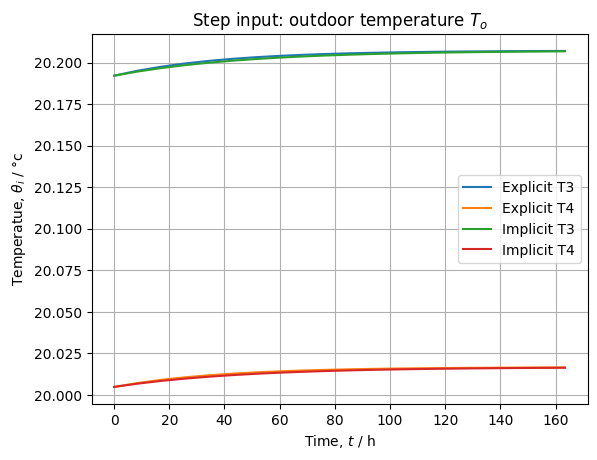

In [30]:
fig, ax = plt.subplots()
ax.plot(t / 3600, yexplicit.T-273, t / 3600, yimplicit.T-273)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °c',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit T3', 'Explicit T4', 'Implicit T3', 'Implicit T4'])
ax.grid()
plt.show()

## Conclusion
La différence obtenue avec les méthodes implicite et explicite est très faible.